In [1]:
# ====================================================================
# STEP 0: Import Libraries
# ====================================================================
# 과제에 사용할 library들을 import

# 시스템 및 입출력 관련
import os  # 디렉토리, 파일 경로 조작 등
from PIL import Image  # 이미지 열기 및 처리 (Pillow)
from tqdm import tqdm  # 반복문의 진행 상태 시각화
from pathlib import Path  # payhon path
import shutil # 파일 복사/이동

# 시각화 도구
import matplotlib.pyplot as plt  # 기본 시각화
import matplotlib
# 한글 폰트 설정 (Windows의 기본 한글 폰트)
matplotlib.rc('font', family='Malgun Gothic')
# 마이너스 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False
import matplotlib.patches as patches

# 주피터 노트북에서 이미지 인라인 표시를 위한 매직 명령어 추가 (여기 추가)
%matplotlib inline

# 이미지 처리
import cv2  # OpenCV - 고급 이미지/비디오 처리

# 수치 연산
import numpy as np  # 배열, 벡터 계산 등

# 통계 tool
import pandas as pd
from collections import defaultdict, Counter

# 싸이킷런 데이터 나누기
from sklearn.model_selection import train_test_split

# JSON
import json

# YOLOv8 라이브러리
from ultralytics import YOLO


In [ ]:
# 디바이스 설정
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# ====================================================================
# STEP 1: Define Paths
# ====================================================================
DATA_ROOT = Path("/Users/user/myproject/AI03-Project-1/data/raw") # 실제 데이터 경로로 변경 필요
train_image_dir = DATA_ROOT / "train_images"
train_ann_path = DATA_ROOT / "train_annotations"
test_image_dir = DATA_ROOT / "test_images"


In [ ]:
# YOLOv8 데이터를 저장할 새 디렉토리
YOLO_DATA_ROOT = DATA_ROOT / "yolov8_dataset"
YOLO_IMAGES_TRAIN = YOLO_DATA_ROOT / "images" / "train"
YOLO_LABELS_TRAIN = YOLO_DATA_ROOT / "labels" / "train"
YOLO_IMAGES_VAL = YOLO_DATA_ROOT / "images" / "val"
YOLO_LABELS_VAL = YOLO_DATA_ROOT / "labels" / "val"
YOLO_LABELS_TEMP = DATA_ROOT / "yolo_labels_temp" # 변환된 .txt 파일을 임시로 저장할 곳


In [ ]:
# 디렉토리 생성
os.makedirs(YOLO_IMAGES_TRAIN, exist_ok=True)
os.makedirs(YOLO_LABELS_TRAIN, exist_ok=True)
os.makedirs(YOLO_IMAGES_VAL, exist_ok=True)
os.makedirs(YOLO_LABELS_VAL, exist_ok=True)
os.makedirs(YOLO_LABELS_TEMP, exist_ok=True)



In [ ]:
# ====================================================================
# STEP 2: Parse Annotations and Convert to YOLO Format
# ====================================================================

def create_yolo_annotations_and_map(annotation_root, train_image_dir, yolo_labels_output_dir):
    """
    원본 JSON 어노테이션을 파싱하고 YOLO 형식(.txt)으로 변환하여 저장합니다.
    또한, 클래스 ID와 이름 매핑 정보를 반환합니다.
    """
    annotations_raw_dict = defaultdict(lambda: {'boxes': [], 'labels': [], 'original_labels': []})
    category_id_to_name = {}

    # 1. 모든 JSON 파일을 스캔하여 category_id_to_name 맵과 원본 어노테이션 정보 수집
    all_json_paths = []
    for dirpath, _, filenames in os.walk(annotation_root):
        for fname in filenames:
            if fname.endswith('.json'):
                all_json_paths.append(os.path.join(dirpath, fname))

    # 모든 JSON에서 카테고리 정보 수집 (클래스 ID 매핑을 위해)
    for json_path in tqdm(all_json_paths, desc="Collecting categories"):
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            if 'categories' in data:
                for cat in data['categories']:
                    category_id_to_name[cat['id']] = cat['name']

    # 정렬된 category_id 목록 (YOLO class_id는 0부터 시작)
    # YOLO의 클래스 ID는 0부터 순차적으로 부여되어야 합니다.
    sorted_category_ids = sorted(list(category_id_to_name.keys()))
    category_id_to_yolo_label_idx = {cat_id: idx for idx, cat_id in enumerate(sorted_category_ids)}
    yolo_label_idx_to_category_name = {idx: category_id_to_name[cat_id] for cat_id, idx in category_id_to_yolo_label_idx.items()}

    print(f"Detected {len(sorted_category_ids)} unique categories.")
    for cat_id in sorted_category_ids:
        print(f"  Original ID: {cat_id}, YOLO ID: {category_id_to_yolo_label_idx[cat_id]}, Name: {category_id_to_name[cat_id]}")


    # 2. 이미지별 어노테이션 파싱 및 YOLO 형식으로 변환하여 파일 저장
    for json_path in tqdm(all_json_paths, desc="Converting annotations to YOLO format"):
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

            image_info = data['images'][0]
            file_name = image_info['file_name'] # 예: K-XXXXX.png

            # 이미지 파일의 실제 경로 찾기 (확장자 유연하게 처리)
            actual_image_path = None
            possible_extensions = ['.png', '.jpg', '.jpeg'] # 필요한 확장자 추가
            for ext in possible_extensions:
                temp_path = train_image_dir / (Path(file_name).stem + ext)
                if temp_path.exists():
                    actual_image_path = temp_path
                    break

            if not actual_image_path:
                print(f"Warning: Image file not found for {file_name}. Skipping annotations for this image.")
                continue

            try:
                with Image.open(actual_image_path) as img:
                    img_w, img_h = img.size
            except Exception as e:
                print(f"Error opening image {actual_image_path}: {e}. Skipping annotations.")
                continue

            yolo_lines = []

            for ann in data['annotations']:
                x, y, w, h = ann['bbox'] # COCO format: [x_min, y_min, width, height]
                original_category_id = ann['category_id']

                # 바운딩 박스 유효성 검사 및 클리핑 (Pascal VOC to safe xyxy for calculation)
                x1 = max(0, x)
                y1 = max(0, y)
                x2 = min(x + w, img_w)
                y2 = min(y + h, img_h)

                if x2 <= x1 or y2 <= y1:
                    # print(f"[Skipped] File: {json_path} | Image: {file_name} -> Invalid bbox: {x,y,w,h}. Clipped to [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}]")
                    continue

                # YOLO 형식으로 변환: [center_x, center_y, width, height] 정규화
                norm_center_x = ((x1 + x2) / 2) / img_w
                norm_center_y = ((y1 + y2) / 2) / img_h
                norm_width = (x2 - x1) / img_w
                norm_height = (y2 - y1) / img_h

                yolo_class_id = category_id_to_yolo_label_idx[original_category_id]
                yolo_lines.append(f"{yolo_class_id} {norm_center_x:.6f} {norm_center_y:.6f} {norm_width:.6f} {norm_height:.6f}")

            # 이미지별로 하나의 .txt 파일 생성
            # 이미지 파일명 (예: K-001900-010224-016551-031705_0_2_0_2_70_000_200.png)의 stem 사용
            output_txt_filename = Path(file_name).stem + ".txt"
            output_txt_path = yolo_labels_output_dir / output_txt_filename

            with open(output_txt_path, 'w', encoding='utf-8') as f:
                f.write('\n'.join(yolo_lines))

            # annotations_raw_dict에 원본 파일명 (file_name) 기반으로 정보 저장
            # 실제 사용될 YOLO 형식의 어노테이션 파일 목록을 만들기 위함
            annotations_raw_dict[file_name] = {
                'yolo_label_path': output_txt_path,
                'image_path': actual_image_path
            }
            # 로깅/확인 목적으로 필요한 경우 원래 박스/라벨을 보관
            # YOLO 훈련 시, DataLoader에서 직접 사용되지 않음
            annotations_raw_dict[file_name]['boxes_pascal_voc'] = [[x1,y1,x2,y2] for ann in data['annotations'] for x,y,w,h in [ann['bbox']] if min(x+w,img_w) > max(0,x) and min(y+h,img_h) > max(0,y)]
            annotations_raw_dict[file_name]['labels_yolo_idx'] = [category_id_to_yolo_label_idx[ann['category_id']] for ann in data['annotations'] if min(ann['bbox'][0]+ann['bbox'][2],img_w) > max(0,ann['bbox'][0]) and min(ann['bbox'][1]+ann['bbox'][3],img_h) > max(0,ann['bbox'][1])]


    print(f"YOLO format annotations saved to: {yolo_labels_output_dir}")
    return annotations_raw_dict, category_id_to_yolo_label_idx, yolo_label_idx_to_category_name


In [ ]:
# YOLO 어노테이션 파일 생성 실행
annotations_info, yolo_class_to_idx, yolo_idx_to_name = create_yolo_annotations_and_map(
    train_ann_path, train_image_dir, YOLO_LABELS_TEMP
)


Detected 73 unique categories.
  Original ID: 1899, YOLO ID: 0, Name: 보령부스파정 5mg
  Original ID: 2482, YOLO ID: 1, Name: 뮤테란캡슐 100mg
  Original ID: 3350, YOLO ID: 2, Name: 일양하이트린정 2mg
  Original ID: 3482, YOLO ID: 3, Name: 기넥신에프정(은행엽엑스)(수출용)
  Original ID: 3543, YOLO ID: 4, Name: 무코스타정(레바미피드)(비매품)
  Original ID: 3742, YOLO ID: 5, Name: 알드린정
  Original ID: 3831, YOLO ID: 6, Name: 뉴로메드정(옥시라세탐)
  Original ID: 4377, YOLO ID: 7, Name: 타이레놀정500mg
  Original ID: 4542, YOLO ID: 8, Name: 에어탈정(아세클로페낙)
  Original ID: 5093, YOLO ID: 9, Name: 삼남건조수산화알루미늄겔정
  Original ID: 5885, YOLO ID: 10, Name: 타이레놀이알서방정(아세트아미노펜)(수출용)
  Original ID: 6191, YOLO ID: 11, Name: 삐콤씨에프정 618.6mg/병
  Original ID: 6562, YOLO ID: 12, Name: 조인스정 200mg
  Original ID: 10220, YOLO ID: 13, Name: 쎄로켈정 100mg
  Original ID: 12080, YOLO ID: 14, Name: 리렉스펜정 300mg/PTP
  Original ID: 12246, YOLO ID: 15, Name: 아빌리파이정 10mg
  Original ID: 12419, YOLO ID: 16, Name: 자이프렉사정 2.5mg
  Original ID: 12777, YOLO ID: 17, Name: 다보타민큐정 10mg/병
  Origin

Converting annotations to YOLO format: 100%|██████████| 4526/4526 [00:02<00:00, 1683.19it/s]

YOLO format annotations saved to: \Users\user\myproject\AI03-Project-1\data\raw\yolo_labels_temp


In [8]:

# ====================================================================
# STEP 3: Organize Data for YOLOv8
# ====================================================================


In [ ]:
# 학습/검증 분할
all_image_filenames = list(annotations_info.keys())
train_img_files, val_img_files = train_test_split(all_image_filenames, test_size=0.2, random_state=42)


In [ ]:
print(f"Total images for training/validation: {len(all_image_filenames)}")
print(f"Train images: {len(train_img_files)}")
print(f"Validation images: {len(val_img_files)}")


Total images for training/validation: 1489
Train images: 1191
Validation images: 298


In [ ]:
# 데이터셋 디렉토리로 파일 복사
print("Copying files to YOLOv8 dataset structure...\n")

# Train 데이터 복사
for img_file in tqdm(train_img_files, desc="Copying train data"):
    img_info = annotations_info.get(img_file)
    if img_info and img_info['image_path'].exists() and img_info['yolo_label_path'].exists():
        shutil.copy(img_info['image_path'], YOLO_IMAGES_TRAIN / img_file)
        shutil.copy(img_info['yolo_label_path'], YOLO_LABELS_TRAIN / img_info['yolo_label_path'].name)
    else:
        print(f"Warning: Missing file for {img_file}. Skipping for train set.")

# Validation 데이터 복사
for img_file in tqdm(val_img_files, desc="Copying validation data"):
    img_info = annotations_info.get(img_file)
    if img_info and img_info['image_path'].exists() and img_info['yolo_label_path'].exists():
        shutil.copy(img_info['image_path'], YOLO_IMAGES_VAL / img_file)
        shutil.copy(img_info['yolo_label_path'], YOLO_LABELS_VAL / img_info['yolo_label_path'].name)
    else:
        print(f"Warning: Missing file for {img_file}. Skipping for validation set.")

print("\nData organized for YOLOv8 training.")        

Copying files to YOLOv8 dataset structure...


Copying validation data: 100%|██████████| 298/298 [00:01<00:00, 168.74it/s]

Data organized for YOLOv8 training.


In [12]:

# ====================================================================
# STEP 4: Create data.yaml file
# ====================================================================


In [ ]:
data_yaml_content = f"""
path: {YOLO_DATA_ROOT}
train: images/train
val: images/val

nc: {len(yolo_class_to_idx)}
names: {list(yolo_idx_to_name.values())}
"""

data_yaml_path = YOLO_DATA_ROOT / "dataset.yaml"
with open(data_yaml_path, 'w', encoding='utf-8') as f:
    f.write(data_yaml_content)

print(f"'dataset.yaml' created at: {data_yaml_path}")
print(data_yaml_content)

'dataset.yaml' created at: \Users\user\myproject\AI03-Project-1\data\raw\yolov8_dataset\dataset.yaml

path: \Users\user\myproject\AI03-Project-1\data\raw\yolov8_dataset
train: images/train
val: images/val

nc: 73
names: ['보령부스파정 5mg', '뮤테란캡슐 100mg', '일양하이트린정 2mg', '기넥신에프정(은행엽엑스)(수출용)', '무코스타정(레바미피드)(비매품)', '알드린정', '뉴로메드정(옥시라세탐)', '타이레놀정500mg', '에어탈정(아세클로페낙)', '삼남건조수산화알루미늄겔정', '타이레놀이알서방정(아세트아미노펜)(수출용)', '삐콤씨에프정 618.6mg/병', '조인스정 200mg', '쎄로켈정 100mg', '리렉스펜정 300mg/PTP', '아빌리파이정 10mg', '자이프렉사정 2.5mg', '다보타민큐정 10mg/병', '써스펜8시간이알서방정 650mg', '에빅사정(메만틴염산염)(비매품)', '리피토정 20mg', '크레스토정 20mg', '가바토파정 100mg', '동아가바펜틴정 800mg', '오마코연질캡슐(오메가-3-산에틸에스테르90)', '란스톤엘에프디티정 30mg', '리리카캡슐 150mg', '종근당글리아티린연질캡슐(콜린알포세레이트)\xa0', '콜리네이트연질캡슐 400mg', '트루비타정 60mg/병', '스토가정 10mg', '노바스크정 5mg', '마도파정', '플라빅스정 75mg', '엑스포지정 5/160mg', '펠루비정(펠루비프로펜)', '아토르바정 10mg', '라비에트정 20mg', '리피로우정 20mg', '자누비아정 50mg', '맥시부펜이알정 300mg', '메가파워정 90mg/병', '쿠에타핀정 25mg', '비타비백정 100mg/병', '놀텍정 10mg', '자누메트정 50/850mg', '큐시드정 31.5mg/PTP', '아

In [14]:

# ====================================================================
# STEP 5: YOLOv8 Model Training
# ====================================================================


In [ ]:
# 모델 로드 (pre-trained YOLOv8n 모델 사용)
model = YOLO('yolov8n.pt') # 'n'ano, 's'mall, 'm'edium, 'l'arge, 'x'large 중 선택


In [ ]:
# 학습 시작
# data 인자에는 위에서 생성한 data.yaml 파일의 경로를 지정
# epochs, imgsz, batch 등 학습 파라미터는 필요에 따라 조절
# device='cpu' 또는 device='0' (GPU 사용 시)
print("Starting YOLOv8 training...")
results = model.train(
    data=str(data_yaml_path), # Path 객체를 문자열로 변환
    epochs=50, # 적절한 에폭 수로 변경
    imgsz=640, # 이미지 크기 (YOLO는 보통 640x640을 많이 사용)
    batch=16,  # 배치 크기
    device=device,
    name='yolov8_pill_detection_run', # 학습 결과가 저장될 폴더 이름
    patience=50, # 50 에폭 동안 검증 성능 개선 없으면 학습 중단
    val=True # 학습 중 검증 수행
)

print("\nYOLOv8 training completed!")


Starting YOLOv8 training...
New https://pypi.org/project/ultralytics/8.3.168 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.167  Python-3.12.10 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=\Users\user\myproject\AI03-Project-1\data\raw\yolov8_dataset\dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mo

train: Scanning C:\Users\user\myproject\AI03-Project-1\data\raw\yolov8_dataset\labels\train.cache... 1191 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1191/1191 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.00.0 ms, read: 308.777.5 MB/s, size: 1878.4 KB)


val: Scanning C:\Users\user\myproject\AI03-Project-1\data\raw\yolov8_dataset\labels\val.cache... 298 images, 0 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


Plotting labels to runs\detect\yolov8_pill_detection_run\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00013, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\yolov8_pill_detection_run
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.12G      0.866      5.132      1.072         11        640: 100%|██████████| 75/75 [00:08<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 11.76it/s]

                   all        298        298          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.46G      0.569      4.558     0.9401         16        640: 100%|██████████| 75/75 [00:07<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.55it/s]

                   all        298        298      0.867     0.0472     0.0826      0.076



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.46G     0.5249      3.988     0.9218         12        640: 100%|██████████| 75/75 [00:07<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.10it/s]


                   all        298        298      0.752      0.194      0.231      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.47G     0.4994      3.531     0.9048         13        640: 100%|██████████| 75/75 [00:07<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.48it/s]


                   all        298        298      0.716      0.218      0.296      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.49G     0.4834      3.109     0.9017         16        640: 100%|██████████| 75/75 [00:07<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]

                   all        298        298      0.632      0.377      0.371      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.51G     0.4441      2.911     0.8953         11        640: 100%|██████████| 75/75 [00:07<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]

                   all        298        298      0.643      0.454      0.405      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.52G     0.4559        2.7     0.8941         16        640: 100%|██████████| 75/75 [00:07<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]

                   all        298        298      0.562      0.553      0.449      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.52G     0.4372      2.529     0.8912         14        640: 100%|██████████| 75/75 [00:07<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]


                   all        298        298       0.56      0.549      0.487      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.52G     0.4144      2.425     0.8821          9        640: 100%|██████████| 75/75 [00:07<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]

                   all        298        298      0.604      0.531      0.504      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.52G     0.4173      2.341     0.8831         14        640: 100%|██████████| 75/75 [00:07<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.52it/s]

                   all        298        298      0.555      0.555      0.494      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.52G     0.4203      2.262     0.8854         12        640: 100%|██████████| 75/75 [00:07<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]

                   all        298        298       0.52      0.646      0.541       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.52G     0.4044      2.151     0.8717         15        640: 100%|██████████| 75/75 [00:07<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]

                   all        298        298      0.505      0.682      0.559      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.52G     0.3925      2.061     0.8716         13        640: 100%|██████████| 75/75 [00:07<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.58it/s]

                   all        298        298      0.517      0.671      0.566      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.52G     0.3876      1.995     0.8666         15        640: 100%|██████████| 75/75 [00:07<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.71it/s]

                   all        298        298      0.523      0.664      0.583      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.52G     0.3749      1.899     0.8605         13        640: 100%|██████████| 75/75 [00:07<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]

                   all        298        298      0.552      0.687      0.609      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.52G     0.3818      1.961     0.8648         14        640: 100%|██████████| 75/75 [00:07<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.42it/s]

                   all        298        298      0.532      0.688      0.574       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.52G     0.3623      1.869     0.8621         13        640: 100%|██████████| 75/75 [00:07<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.81it/s]

                   all        298        298      0.484      0.755      0.595      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.52G     0.3696      1.827     0.8615         14        640: 100%|██████████| 75/75 [00:07<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


                   all        298        298      0.536       0.67      0.596      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.52G     0.3693      1.796     0.8674         12        640: 100%|██████████| 75/75 [00:07<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.77it/s]

                   all        298        298       0.49      0.691      0.586      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.52G     0.3603      1.837     0.8563         11        640: 100%|██████████| 75/75 [00:07<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


                   all        298        298      0.504      0.693      0.577      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.52G     0.3496      1.756     0.8544         12        640: 100%|██████████| 75/75 [00:07<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]

                   all        298        298      0.455      0.785        0.6      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.52G     0.3493      1.708     0.8523         16        640: 100%|██████████| 75/75 [00:07<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.43it/s]

                   all        298        298       0.49      0.765      0.601      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.52G     0.3436      1.706     0.8514          7        640: 100%|██████████| 75/75 [00:07<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.35it/s]


                   all        298        298      0.568      0.685      0.593       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.52G     0.3408      1.666     0.8556         12        640: 100%|██████████| 75/75 [00:07<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]

                   all        298        298       0.48      0.702      0.606      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.53G     0.3362      1.628     0.8468         11        640: 100%|██████████| 75/75 [00:07<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.82it/s]

                   all        298        298      0.578      0.644      0.615      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.55G     0.3382      1.595     0.8564         15        640: 100%|██████████| 75/75 [00:07<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.23it/s]

                   all        298        298      0.535      0.707      0.609        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.55G     0.3291      1.641     0.8502         14        640: 100%|██████████| 75/75 [00:07<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.56it/s]

                   all        298        298      0.552       0.67      0.629      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.55G     0.3338        1.6     0.8523         11        640: 100%|██████████| 75/75 [00:07<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.57it/s]

                   all        298        298      0.533      0.753      0.637      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.55G     0.3175      1.583     0.8487         17        640: 100%|██████████| 75/75 [00:07<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.02it/s]

                   all        298        298      0.498      0.749      0.631      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.55G     0.3296      1.567     0.8518         17        640: 100%|██████████| 75/75 [00:07<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]

                   all        298        298      0.553      0.714      0.643      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.55G     0.3201      1.531     0.8479         15        640: 100%|██████████| 75/75 [00:07<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.34it/s]

                   all        298        298      0.481      0.807      0.617      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.55G      0.318      1.545     0.8385         12        640: 100%|██████████| 75/75 [00:07<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.54it/s]

                   all        298        298      0.514      0.746      0.628      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.55G     0.3224      1.545     0.8452         10        640: 100%|██████████| 75/75 [00:07<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.37it/s]

                   all        298        298      0.502      0.724      0.644      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.55G     0.3102       1.47     0.8374         14        640: 100%|██████████| 75/75 [00:07<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.51it/s]

                   all        298        298      0.562      0.726      0.659      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.55G     0.3128      1.515     0.8434          9        640: 100%|██████████| 75/75 [00:07<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


                   all        298        298      0.499       0.79      0.642      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.55G     0.3183      1.509     0.8552         12        640: 100%|██████████| 75/75 [00:07<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


                   all        298        298      0.527       0.75      0.643      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.55G     0.3111      1.443     0.8424         14        640: 100%|██████████| 75/75 [00:07<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]

                   all        298        298      0.567      0.703      0.638      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.55G     0.3212      1.499     0.8473         10        640: 100%|██████████| 75/75 [00:07<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]

                   all        298        298      0.502      0.777      0.642      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.55G     0.3034      1.458     0.8442         14        640: 100%|██████████| 75/75 [00:07<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.56it/s]

                   all        298        298      0.558      0.728      0.663       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.55G     0.3019      1.483     0.8332         10        640: 100%|██████████| 75/75 [00:07<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.65it/s]

                   all        298        298      0.548      0.752      0.646      0.634


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.55G     0.2418      1.635     0.8024          7        640: 100%|██████████| 75/75 [00:08<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]

                   all        298        298      0.588      0.715      0.632       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.55G     0.2354      1.596     0.8035          7        640: 100%|██████████| 75/75 [00:07<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.17it/s]

                   all        298        298      0.568      0.734      0.632      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.55G     0.2331      1.574     0.8071          7        640: 100%|██████████| 75/75 [00:07<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.57it/s]

                   all        298        298      0.553      0.766      0.628      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.55G     0.2304      1.551     0.8065          7        640: 100%|██████████| 75/75 [00:07<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


                   all        298        298      0.548       0.76      0.646      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.55G     0.2294      1.544     0.8006          7        640: 100%|██████████| 75/75 [00:07<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.93it/s]

                   all        298        298      0.562      0.746      0.645      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.55G     0.2215      1.488     0.8092          7        640: 100%|██████████| 75/75 [00:07<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.31it/s]

                   all        298        298      0.561      0.747       0.65      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.55G     0.2267       1.52     0.8075          7        640: 100%|██████████| 75/75 [00:07<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.36it/s]

                   all        298        298      0.566      0.749      0.648      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.55G     0.2216      1.512     0.8112          7        640: 100%|██████████| 75/75 [00:07<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.91it/s]


                   all        298        298      0.549      0.778      0.653      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.55G     0.2191      1.494     0.8028          6        640: 100%|██████████| 75/75 [00:07<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.69it/s]

                   all        298        298      0.557      0.743      0.659      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.55G     0.2196      1.498     0.7973          7        640: 100%|██████████| 75/75 [00:07<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  8.53it/s]


                   all        298        298      0.554      0.758      0.652      0.642

50 epochs completed in 0.131 hours.
Optimizer stripped from runs\detect\yolov8_pill_detection_run\weights\last.pt, 6.4MB
Optimizer stripped from runs\detect\yolov8_pill_detection_run\weights\best.pt, 6.4MB

Validating runs\detect\yolov8_pill_detection_run\weights\best.pt...
Ultralytics 8.3.167  Python-3.12.10 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
Model summary (fused): 72 layers, 3,091,487 parameters, 0 gradients, 8.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  7.75it/s]


                   all        298        298      0.558      0.743      0.659      0.651
            2mg          2          2          1          0      0.359      0.359
     ()()          1          1          1          0          0          0
          ()          1          1      0.578          1      0.995      0.895
                   2          2          1          0     0.0905      0.073
()()          1          1          1          0      0.124      0.124
       618.6mg/          2          2      0.208        0.5      0.373      0.373
             200mg          1          1          0          0          0          0
        300mg/PTP          2          2      0.267        0.5      0.373      0.373
            10mg          1          1          0          0          0          0
          10mg/          6          6      0.454          1      0.825       0.81
     8 650mg          4          4      0.567       0.75      0.538      0.538
     ()()          2          2 

In [17]:

# 학습된 모델은 'runs/detect/yolov8_pill_detection_run/weights/best.pt' 경로에 저장.


In [18]:

# ====================================================================
# STEP 6: YOLOv8 Model Inference on Test Images
# ====================================================================


In [ ]:
# 학습된 모델 로드 (학습 결과 폴더에서 best.pt 파일 경로를 확인하여 지정)
trained_model_path = Path(results.save_dir) / "weights" / "best.pt"
if trained_model_path.exists():
    inference_model = YOLO(str(trained_model_path))
    print(f"Loading trained model from: {trained_model_path}")
else:
    print(f"Error: Trained model not found at {trained_model_path}. Please check training output.")
    # If model not found, try loading the default 'yolov8n.pt' for inference
    inference_model = YOLO('yolov8n.pt')
    print("Using default yolov8n.pt for inference.")

Loading trained model from: runs\detect\yolov8_pill_detection_run\weights\best.pt


In [ ]:

# 테스트 이미지 폴더
test_image_dir = DATA_ROOT / "test_images"

if not test_image_dir.exists():
    print(f"Error: Test image directory not found at {test_image_dir}")
else:
    print(f"Starting YOLOv8 inference on test images from: {test_image_dir}")
    # 추론 실행
    # 'source' 인자에 이미지 폴더 경로 지정
    # 'save=True': 결과 이미지 저장
    # 'save_txt=True': YOLO 형식 텍스트 파일로 결과 저장 (class conf_score x_norm y_norm w_norm h_norm)
    # 'save_conf=True': confidence score도 함께 저장
    # 'conf': confidence threshold
    # 'iou': NMS IoU threshold
    inference_results = inference_model(
        source=str(test_image_dir),
        save=True,
        save_txt=True,
        save_conf=True,
        conf=0.25, # 최소 confidence score (조절 가능)
        iou=0.7,   # NMS (Non-Maximum Suppression) IOU threshold (조절 가능)
        project='yolov8_inference_results', # 결과 저장할 상위 폴더
        name='test_predictions_run', # 결과 저장할 하위 폴더
        device=device
    )

    print("\nYOLOv8 inference completed!")
    print(f"Inference results saved to: {Path(inference_results[0].save_dir).parent}")

Starting YOLOv8 inference on test images from: \Users\user\myproject\AI03-Project-1\data\raw\test_images

image 1/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\1.png: 640x512 1  800mg, 1  10mg, 1 , 29.9ms
image 2/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\10.png: 640x512 1  20mg, 1 , 6.4ms
image 3/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\100.png: 640x512 1  100mg, 1 , 6.9ms
image 4/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\1003.png: 640x512 1  50/1000mg, 7.8ms
image 5/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\1004.png: 640x512 1  50/1000mg, 7.0ms
image 6/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\1005.png: 640x512 1  40/5mg, 1  50/1000mg, 7.1ms
image 7/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\1006.png: 640x512 1  50/850mg, 1  5/100mg, 7.1ms
image 8/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\1007.png: 640x512 1  50/850

Displaying first inference result (if available)...


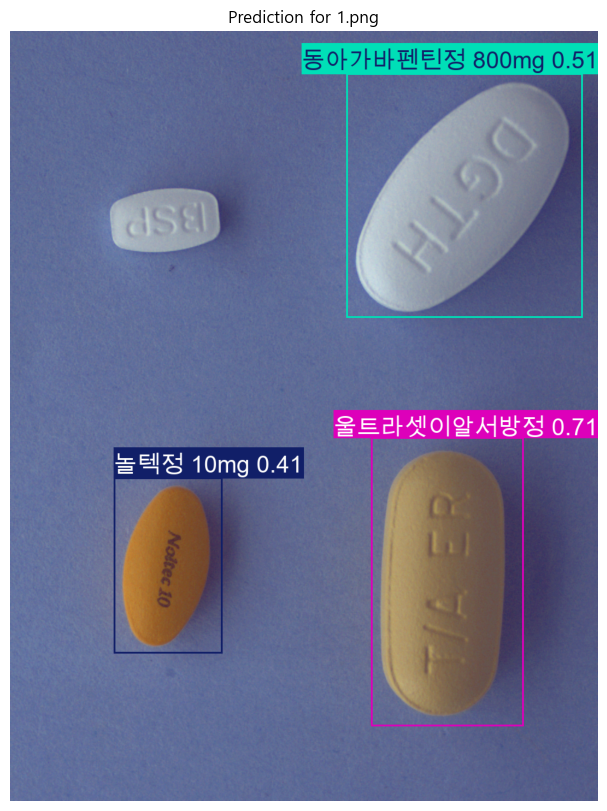

First image's detections:
  - Class: 울트라셋이알서방정 (YOLO ID: 51), Conf: 0.71, Bbox (norm xywh): [0.7440731525421143, 0.7150046229362488, 0.25946494936943054, 0.3749122619628906]
  - Class: 동아가바펜틴정 800mg (YOLO ID: 23), Conf: 0.51, Bbox (norm xywh): [0.7732682228088379, 0.21376781165599823, 0.4012283384799957, 0.31664448976516724]
  - Class: 놀텍정 10mg (YOLO ID: 44), Conf: 0.41, Bbox (norm xywh): [0.2690037488937378, 0.6942710280418396, 0.18370693922042847, 0.22784052789211273]


In [ ]:
# 추론 결과 시각화 예시 (옵션)
# inference_results는 Results 객체의 리스트입니다.
if inference_results:
    print("Displaying first inference result (if available)...")
    first_result = inference_results[0]
    im_bgr = first_result.plot() # BGR 이미지 (OpenCV 형식)
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB) # RGB로 변환 (matplotlib용)

    plt.figure(figsize=(10, 10))
    plt.imshow(im_rgb)
    plt.title(f"Prediction for {Path(first_result.path).name}")
    plt.axis('off')
    plt.show()

    # 바운딩 박스 정보 출력 예시
    print("First image's detections:")
    for box_data in first_result.boxes:
        cls = int(box_data.cls)
        conf = float(box_data.conf)
        xywh_norm = box_data.xywhn[0].tolist() # 정규화된 xywh

        # YOLO 클래스 ID를 실제 카테고리 이름으로 변환
        class_name = yolo_idx_to_name.get(cls, f"Unknown_{cls}")
        print(f"  - Class: {class_name} (YOLO ID: {cls}), Conf: {conf:.2f}, Bbox (norm xywh): {xywh_norm}")

In [ ]:
# ====================================================================
# (Optional) 임시 파일 삭제
# ====================================================================
shutil.rmtree(YOLO_LABELS_TEMP)
print(f"Removed temporary YOLO label directory: {YOLO_LABELS_TEMP}")

Removed temporary YOLO label directory: \Users\user\myproject\AI03-Project-1\data\raw\yolo_labels_temp
